# DATASET I 

In [1]:
%matplotlib inline
import itertools
import warnings
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statistics import *
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.layers import Dropout
from pmdarima import auto_arima 
from time import process_time
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense
from numpy import log
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

Using TensorFlow backend.
D:\aaaaaaaa\envs\tf\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\aaaaaaaa\envs\tf\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\aaaaaaaa\envs\tf\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\aaaaaaaa\envs\tf\lib\site-packages\tensorboard\compat\tensorflow_stub\d

In [2]:
warnings.filterwarnings("ignore")

## Reading Dataset I 

In [69]:
dt_1 = pd.read_csv(r'C:\Users\Sam\Downloads\beer/monthly-beer-production-in-austr.csv')
dt_1.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


## Setting Index to month 

In [73]:
dt_1.Month = pd.to_datetime(dt_1.Month)
dt_1 = dt_1.set_index("Month")
print(dt_1.count())

Monthly beer production    476
dtype: int64


In [74]:
dt_1.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


### Checking the stationarity of the model 

In [5]:
X = log(dt_1)
r = adfuller(X)
print('ADF Statistic: %f' % r[0])
print('p-value: %f' % r[1])
for key, value in r[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -2.800769
p-value: 0.058164
	1%: -3.445
	5%: -2.868
	10%: -2.570


## Seasonal Decomposition Plots of Time series

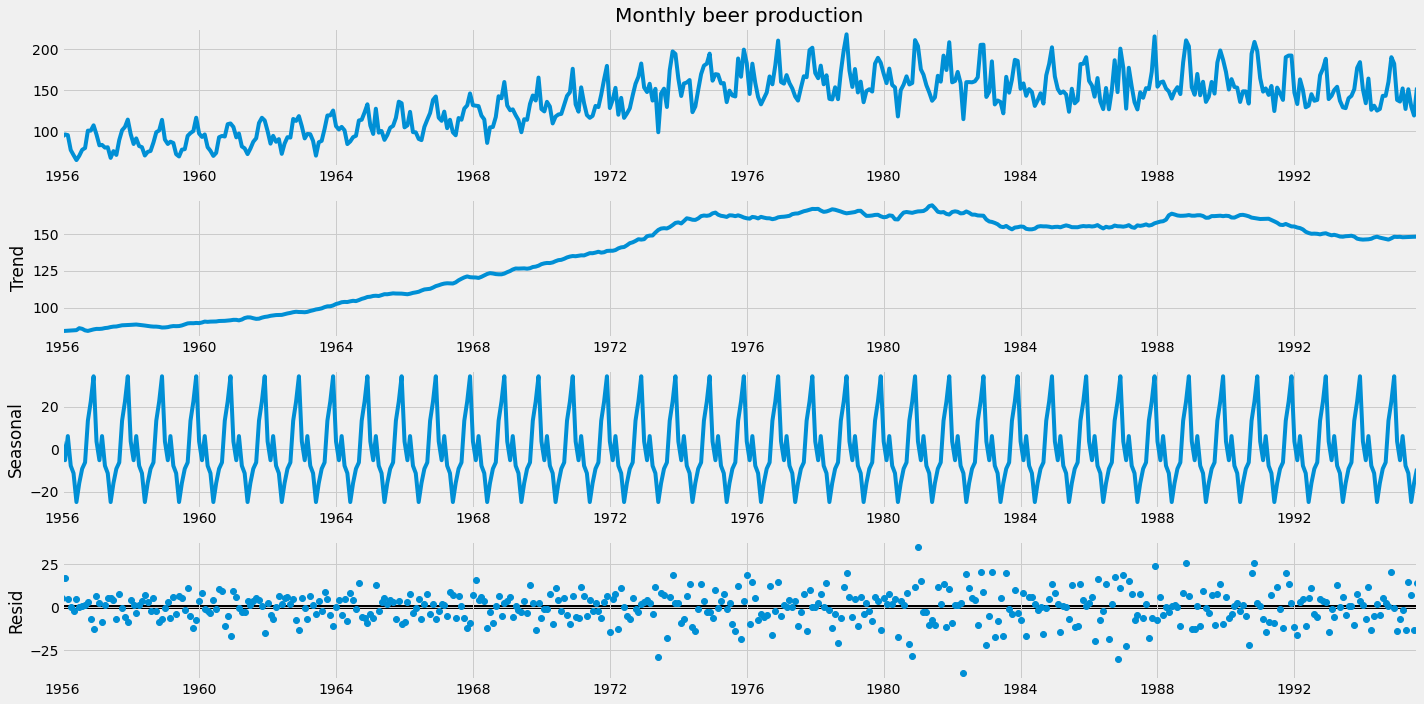

In [6]:
plt.style.use('fivethirtyeight')
result_add = seasonal_decompose(dt_1['Monthly beer production'],
                                model='additive',
                                extrapolate_trend='freq',
                                freq=12)

plt.rcParams.update({'figure.figsize': (20, 10)})
result_add.plot()
plt.show()

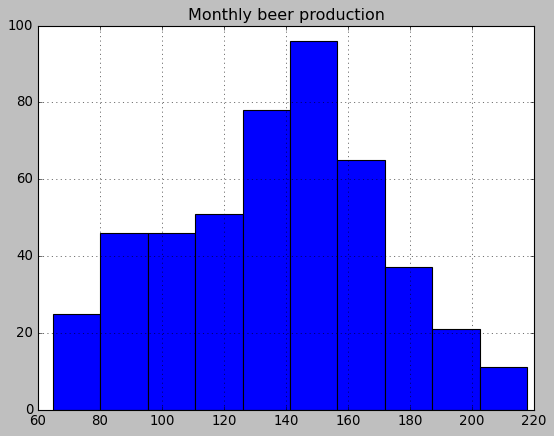

In [7]:
plt.style.use('classic')
dt_1.hist()
plt.show()

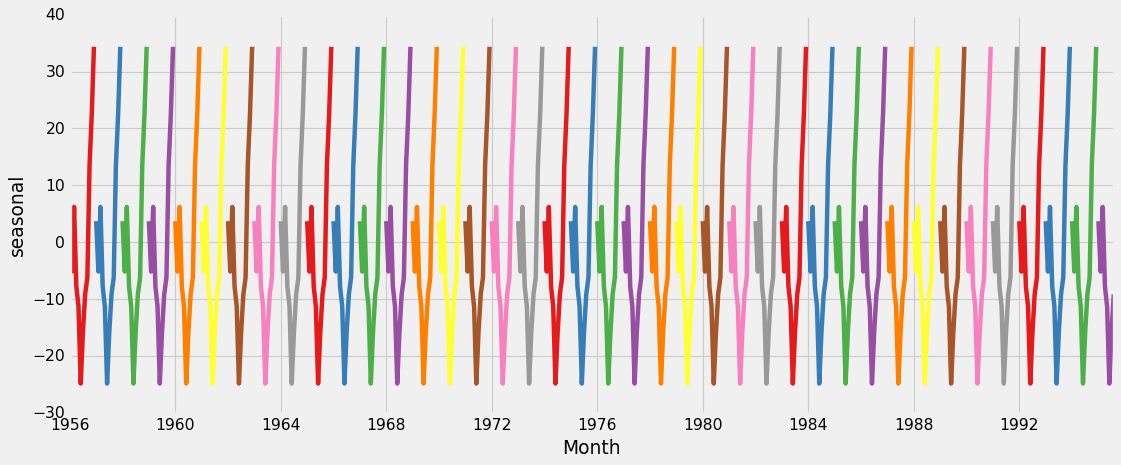

In [8]:
plt.style.use('fivethirtyeight')
df_mean1 = dt_1['Monthly beer production'].rolling(window=30).mean()

plt.figure(figsize=(15,6))
sns.lineplot(x=dt_1.index,y=result_add.seasonal,data=dt_1,hue=dt_1.index.year,palette='Set1',legend=False)

plt.show()

## SARIMA

In [9]:
p = d = q = range(0, 4)
#generate patterns from p,q,r
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [10]:
'''t = process_time()
aic = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                dt_1['Monthly beer production'],
                order=param, seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False)
            results = mod.fit()
            #print('SARIMA{}*{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            aic.append(results.aic)
        except:
            continue

print(t-process_time())'''

"t = process_time()\naic = []\nfor param in pdq:\n    for param_seasonal in seasonal_pdq:\n        try:\n            mod = sm.tsa.statespace.SARIMAX(\n                dt_1['Monthly beer production'],\n                order=param, seasonal_order=param_seasonal,\n                enforce_stationarity=False,\n                enforce_invertibility=False)\n            results = mod.fit()\n            #print('SARIMA{}*{}12 - AIC:{}'.format(param, param_seasonal, results.aic))\n            aic.append(results.aic)\n        except:\n            continue\n\nprint(t-process_time())"

In [11]:
train_data = dt_1[:len(dt_1)-12]
test_data = dt_1[len(dt_1)-12:]
train_data.count()

Monthly beer production    464
dtype: int64

In [12]:
t = process_time()
arima_model = SARIMAX(train_data['Monthly beer production'],
                      order = (2,1,1), seasonal_order = (4,0,3,12))
arima_result = arima_model.fit()

elapsed_time = process_time() - t
arima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                    Monthly beer production   No. Observations:                  464
Model:             SARIMAX(2, 1, 1)x(4, 0, [1, 2, 3], 12)   Log Likelihood               -1707.953
Date:                                    Fri, 03 Sep 2021   AIC                           3437.906
Time:                                            17:24:07   BIC                           3483.421
Sample:                                        01-01-1956   HQIC                          3455.824
                                             - 08-01-1994                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1189      0.043     -2.792      0.005      -0.202      -0.035
ar.L2         -0.1641      0.044     -3.703      0.000      -0.251      -0.077
ma.L1         -0.8508      0.027    -31.694      0.000      -0.903      -0.798
ar.S.L12       1.7637      0.096     18.355      0.000       1.575       1.952
ar.S.L24      -1.6218      0.172     -9.453      0.000      -1.958      -1.286
ar.S.L36       0.7950      0.128      6.212      0.000       0.544       1.046
ar.S.L48       0.0619      0.048      1.297      0.195      -0.032       0.155
ma.S.L12      -1.5603      0.111    -14.043      0.000      -1.778      -1.343
ma.S.L24       1.3929      0.173      8.055      0.000       1.054       1.732
ma.S.L36      -0.6564      0.099     -6.598      0.000      -0.851      -0.461
sigma2        84.2157      4.851     17.360      0.000      74.708      93.724
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                41.75
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               4.09   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
print(elapsed_time)

21.453125


In [14]:
print(dt_1.iloc[len(train_data)])
print(dt_1.tail())

Monthly beer production    143.0
Name: 1994-09-01 00:00:00, dtype: float64
            Monthly beer production
Month                              
1995-04-01                    127.0
1995-05-01                    151.0
1995-06-01                    130.0
1995-07-01                    119.0
1995-08-01                    153.0


### ARIMA train predictions

In [15]:
arima_train_pred = arima_result.predict(start = pd.to_datetime('1956-01-01 	'),
                                        end = len(train_data)-1,
                                        typ="levels",
                                        enforce_stationarity=False,
                                        enforce_invertibility=False).rename("ARIMA Predictions")

In [16]:
arima_train_rmse_error = rmse(train_data['Monthly beer production'], arima_train_pred)
mean_value = dt_1['Monthly beer production'].mean()

### ARIMA test predictions

In [17]:
arima_pred = arima_result.predict(start = len(train_data),
                                  end = len(dt_1)-1,
                                  typ="levels",
                                  enforce_stationarity=False,
                                  enforce_invertibility=False).rename("ARIMA Predictions")

### getting the confidence intervals

In [18]:
pred = arima_result.get_prediction(start=pd.to_datetime('1994-09-01'), end = len(dt_1)-1,
                              dynamic=False)
pred_ci = pred.conf_int()

### plotting actual vs forecast test set

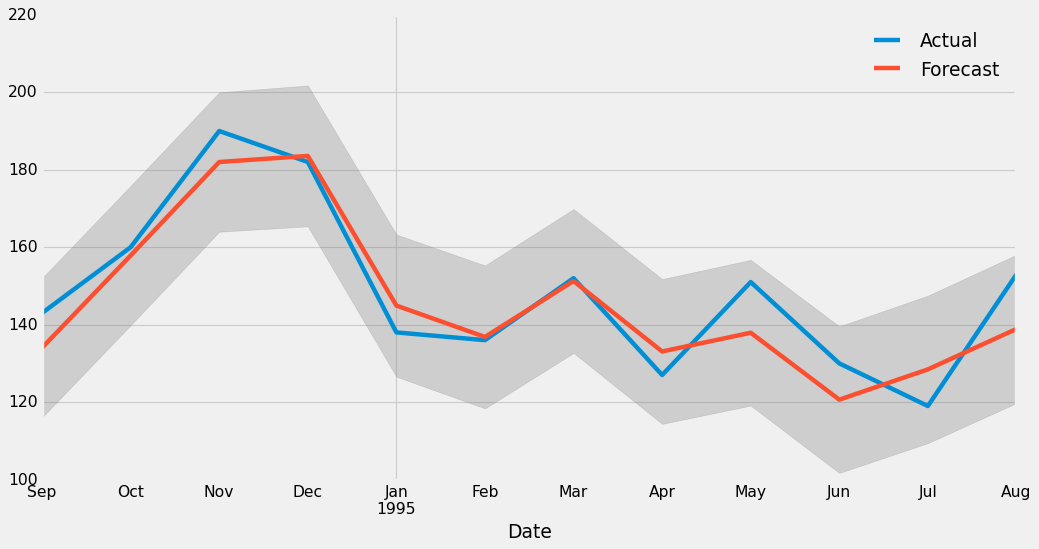

In [19]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(14,7))
ax = test_data['Monthly beer production'].plot(label='Actual')
arima_pred.plot(ax=ax, label='Forecast')

#confidence intervals
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='grey', alpha=.3)
ax.set_xlabel('Date')
plt.legend()
plt.show()

### RMSE - test set

In [20]:
arima_rmse_error = rmse(test_data['Monthly beer production'], arima_pred)
mean_value = dt_1['Monthly beer production'].mean()

print(f'Train data RMSE Error: {arima_train_rmse_error}')
print(f'Test data RMSE Error: {arima_rmse_error}\nMean: {mean_value}')

Train data RMSE Error: 10.520917954841856
Test data RMSE Error: 8.085260654355828
Mean: 136.3953781512605


In [21]:
test_data['ARIMA_Predictions'] = arima_pred

In [22]:
#scaling data for LSTM
scaler = MinMaxScaler()
scaler.fit(pd.DataFrame(train_data))
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data.iloc[:,:1])

### building LSTM model 

In [23]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)


lstm_model = Sequential()

lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))


lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


### training LSTM 

In [24]:
t = process_time()
lstm_model.fit(generator,epochs=40,verbose=0)
elapsed_time = process_time() - t 
print(elapsed_time) 

409.609375


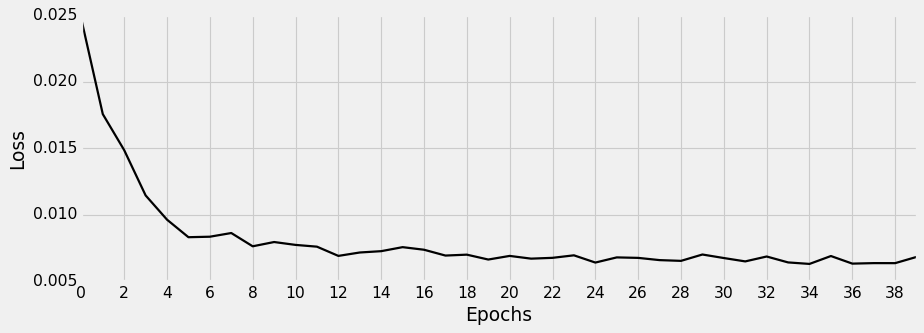

In [25]:
losses_lstm = lstm_model.history.history['loss']

plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,40,2))
plt.plot(range(len(losses_lstm)),losses_lstm,lw=2, color = 'black')
plt.show()

In [26]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]

current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [27]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

test_data['LSTM_Predictions'] = lstm_predictions

test_data

,Monthly beer production,ARIMA_Predictions,LSTM_Predictions
Month,,,
1994-09-01,143.0,134.039248,140.466454
1994-10-01,160.0,157.859830,149.723437
1994-11-01,190.0,181.997222,166.006697
1994-12-01,182.0,183.572007,165.879507
1995-01-01,138.0,144.925254,144.103283
1995-02-01,136.0,136.832723,139.863130
1995-03-01,152.0,151.274838,149.313879
1995-04-01,127.0,133.078726,129.562483
1995-05-01,151.0,137.915726,129.962615


### Comparison of 2 models on test data

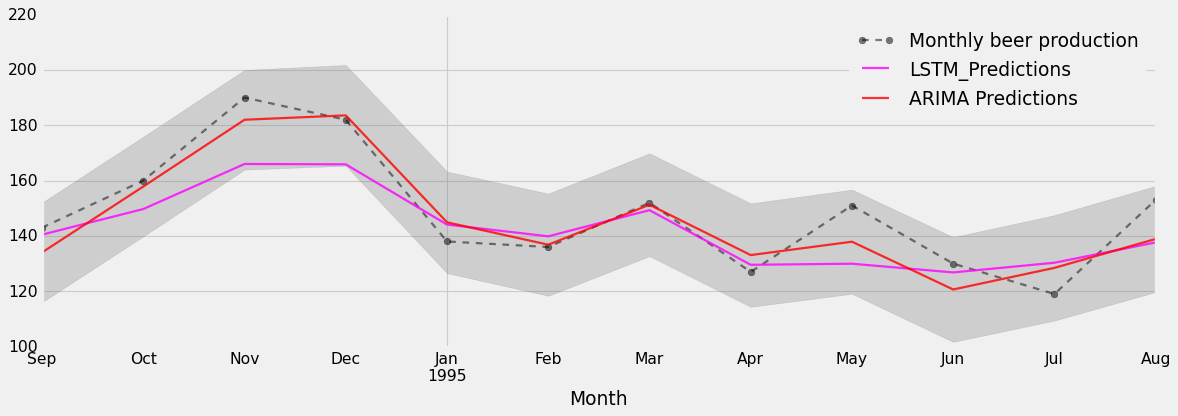

In [28]:
plt.style.use('fivethirtyeight')

ax = test_data['Monthly beer production'].plot(figsize = (16,5),
                                          style='--',
                                          color='black',
                                          lw = 2,
                                          marker = 'o',
                                          legend=True,
                                          alpha=0.5)
test_data['LSTM_Predictions'].plot(lw=2,
                                   color='magenta',
                                   legend = True,
                                   alpha=0.8);
arima_pred.plot(lw=2,
                color = 'r',
                legend=True,
                alpha=0.8)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='grey', alpha=.3)
plt.show()

In [29]:
lstm_rmse_error = rmse(test_data['Monthly beer production'], test_data["LSTM_Predictions"])
lstm_mse_error = lstm_rmse_error**2
mean_value = dt_1['Monthly beer production'].mean()

print(f'LSTM test RMSE Error: {lstm_rmse_error}')
print(f'ARIMA Test RMSE Error: {arima_rmse_error}')

LSTM test RMSE Error: 12.347218829950545
ARIMA Test RMSE Error: 8.085260654355828


# DATASET II

In [30]:
df1 = pd.read_csv(r'C:\Users\Sam\Downloads\beer/city_temperature.csv',header=0,
                  low_memory=False ,
                  parse_dates= {"date" : ["Month","Day","Year"]})

#converting datatype to datetime 
df1['date'] = pd.to_datetime(df1['date'], errors = 'coerce' )
df1.dtypes

date              datetime64[ns]
Region                    object
Country                   object
State                     object
City                      object
AvgTemperature           float64
dtype: object

### Subsetting the data

In [31]:
dt_2 = df1[df1["Country"]== 'Sri Lanka']

#checking for duplicates
print(len(dt_2) != len(set(dt_2)))
dup = dt_2[dt_2.duplicated()]
print(dup)

True
Empty DataFrame
Columns: [date, Region, Country, State, City, AvgTemperature]
Index: []


In [77]:
df.head()

,AvgTemperature
date,
2016-01-01,80.8
2016-01-02,80.4
2016-01-03,81.9
2016-01-04,82.4
2016-01-05,81.6


In [32]:
df = dt_2[["date", "AvgTemperature"]]
print(df.count())
print(df.describe())

date              9266
AvgTemperature    9266
dtype: int64
       AvgTemperature
count     9266.000000
mean        74.241420
std         35.401923
min        -99.000000
25%         79.700000
50%         81.500000
75%         82.900000
max         88.300000


In [33]:
#subsetting the data for particular dates
mask = (df['date'] >= '2016-01-01') & (df['date'] <= '2020-05-10')
df = df.loc[mask]
df.set_index('date', inplace=True)
print(df.count())

AvgTemperature    1592
dtype: int64


### Checking for outliers

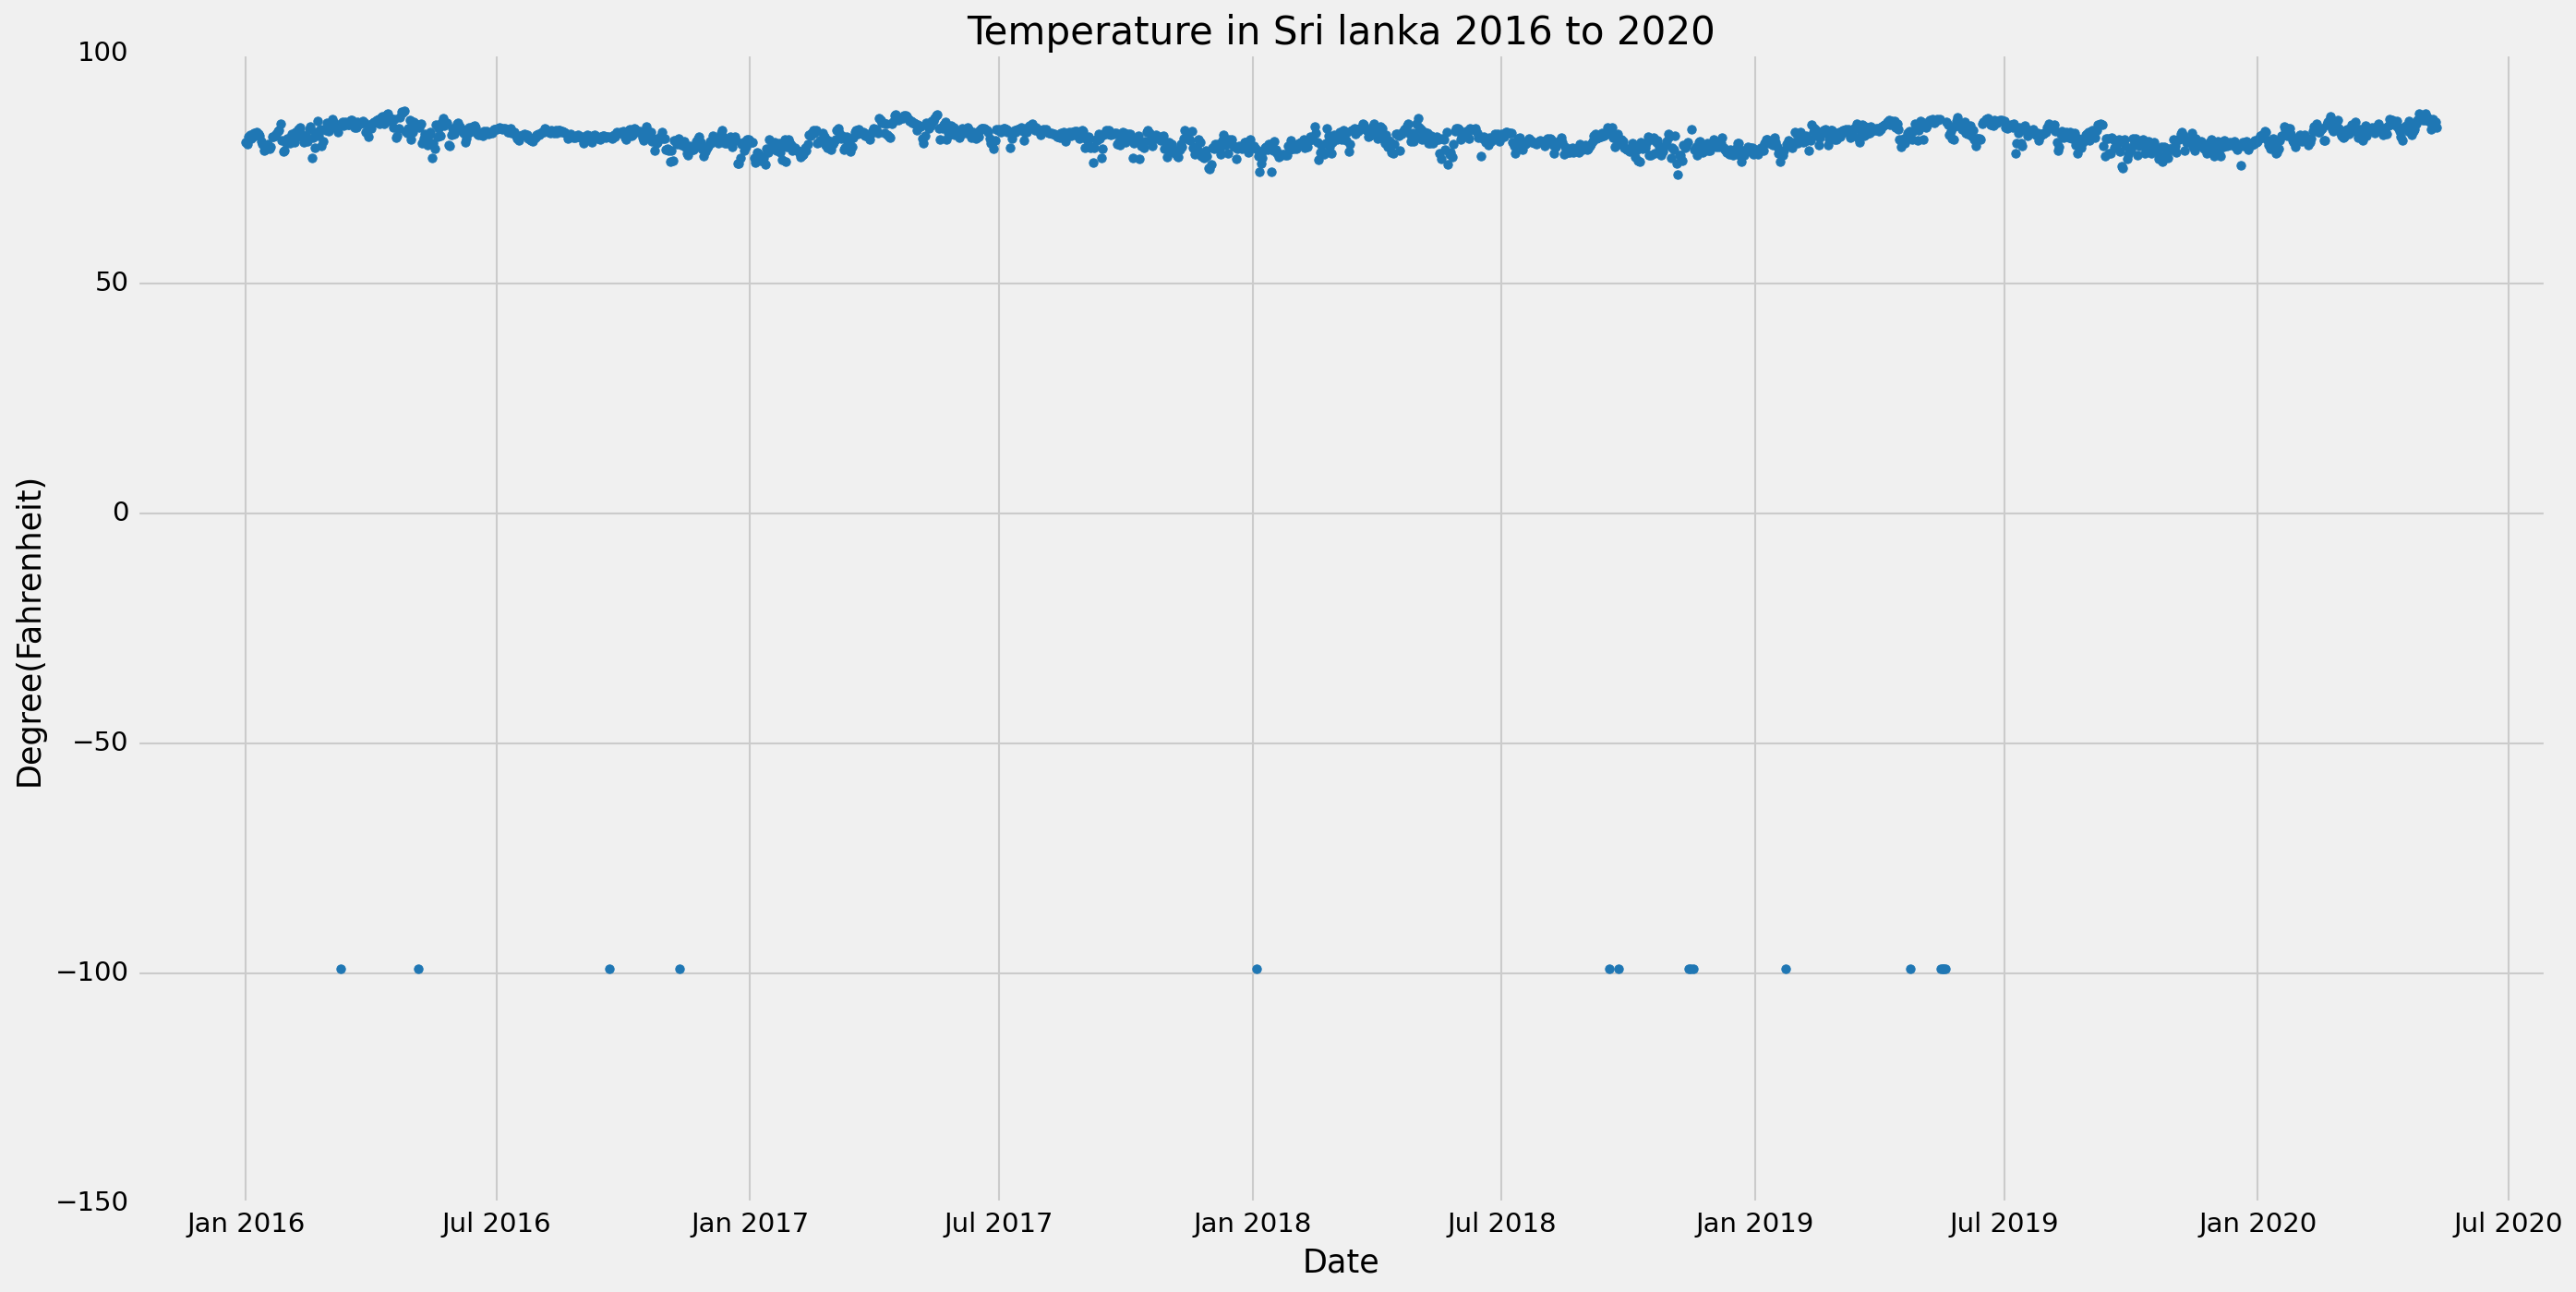

In [34]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(20, 10), dpi=150)

plt.scatter(df.index, df.AvgTemperature, color='tab:blue')

plt.gca().set(title='Temperature in Sri lanka 2016 to 2020', 
              xlabel='Date', ylabel='Degree(Fahrenheit)')
plt.show()

In [35]:
df["AvgTemperature"] = df["AvgTemperature"].mask(df["AvgTemperature"] == -99, median)

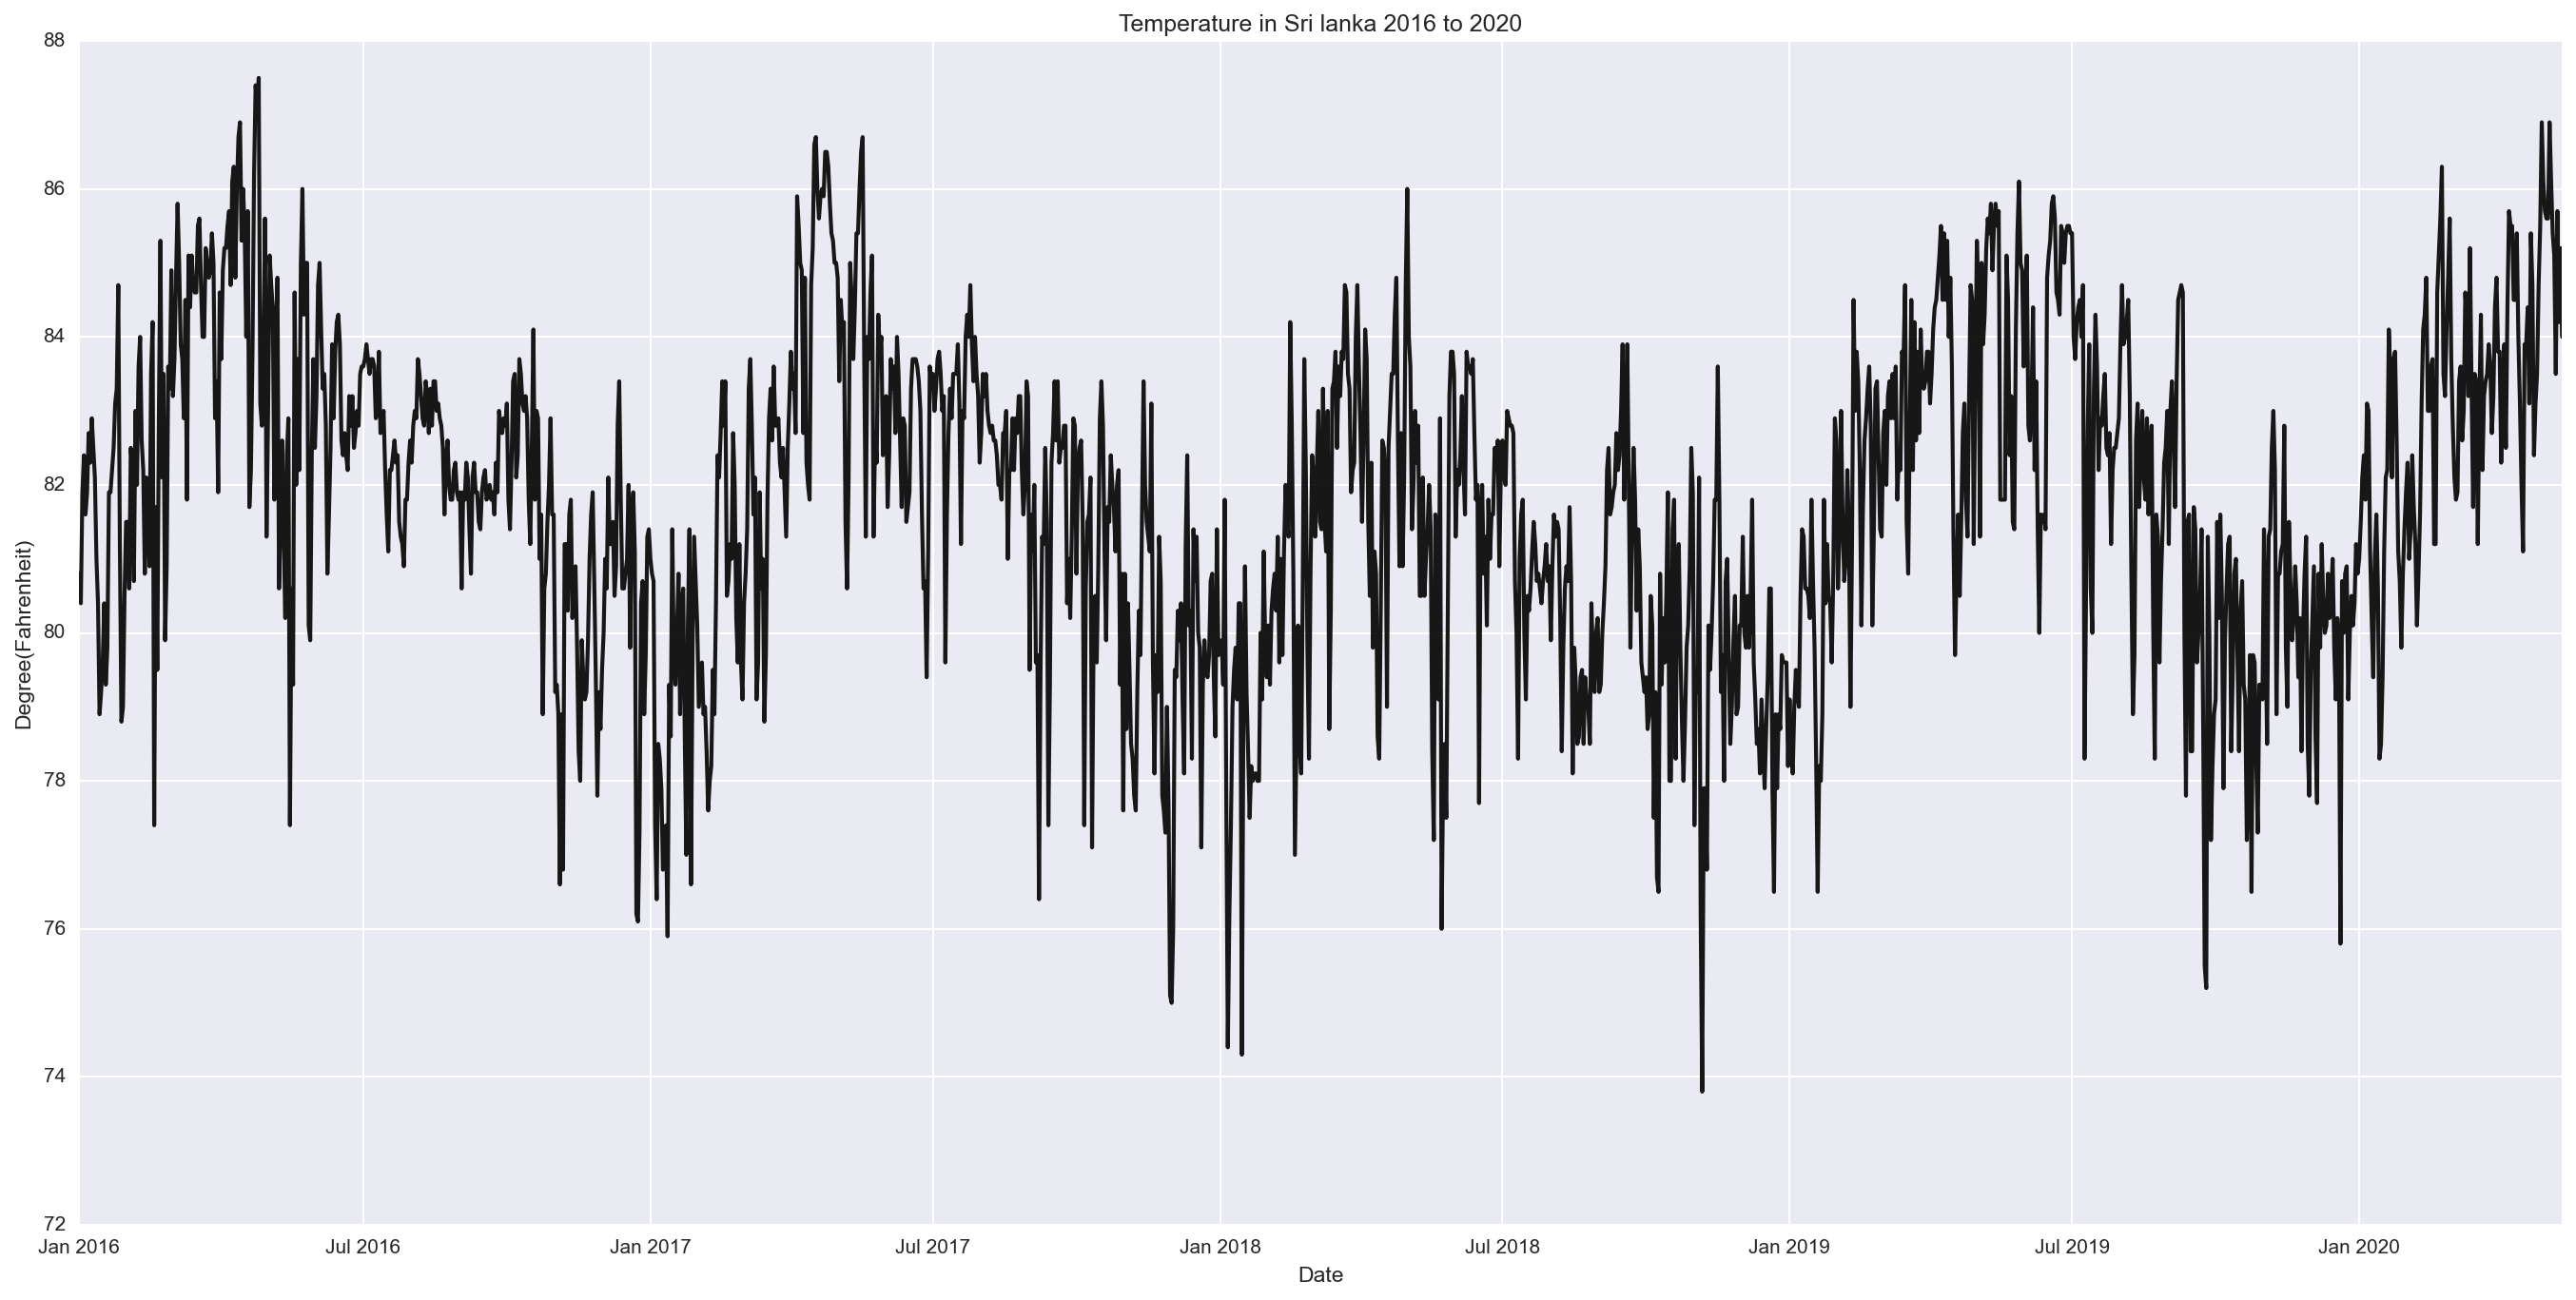

In [36]:
plt.style.use('seaborn')
plt.figure(figsize=(20, 10), dpi=150)
plt.plot(df.index, df.AvgTemperature, color='black',lw=2,alpha=0.9)
plt.gca().set(title='Temperature in Sri lanka 2016 to 2020', 
xlabel='Date', ylabel='Degree(Fahrenheit)')
plt.show()

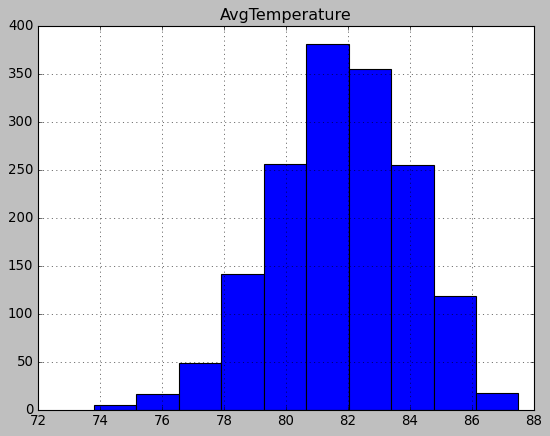

In [37]:
plt.style.use('classic')
df.hist()
plt.show()

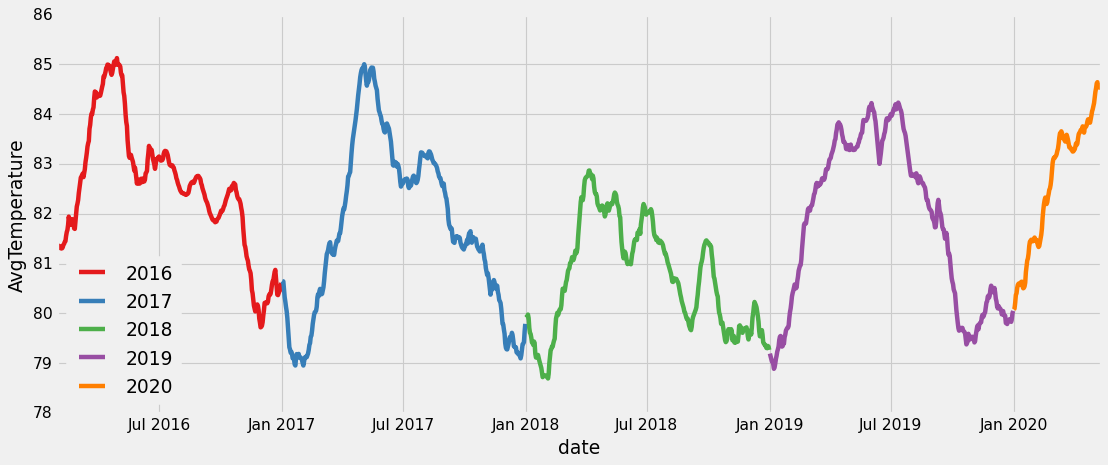

In [38]:
plt.style.use('fivethirtyeight')
df_mean = df.AvgTemperature.rolling(window=30).mean()

plt.figure(figsize=(15,6))
sns.lineplot(x=df.index,y=df_mean ,data=df,hue=df.index.year,palette='Set1')
plt.legend(loc='best')
plt.show()

In [39]:
X = log(df)
r = adfuller(X)
print('ADF Statistic: %f' % r[0])
print('p-value: %f' % r[1])
for key, value in r[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -4.203537
p-value: 0.000650
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [40]:
result_ts = seasonal_decompose(df.AvgTemperature,
                                model='additive',
                                extrapolate_trend='freq',
                                freq=365)

plt.rcParams.update({'figure.figsize': (20, 10)})

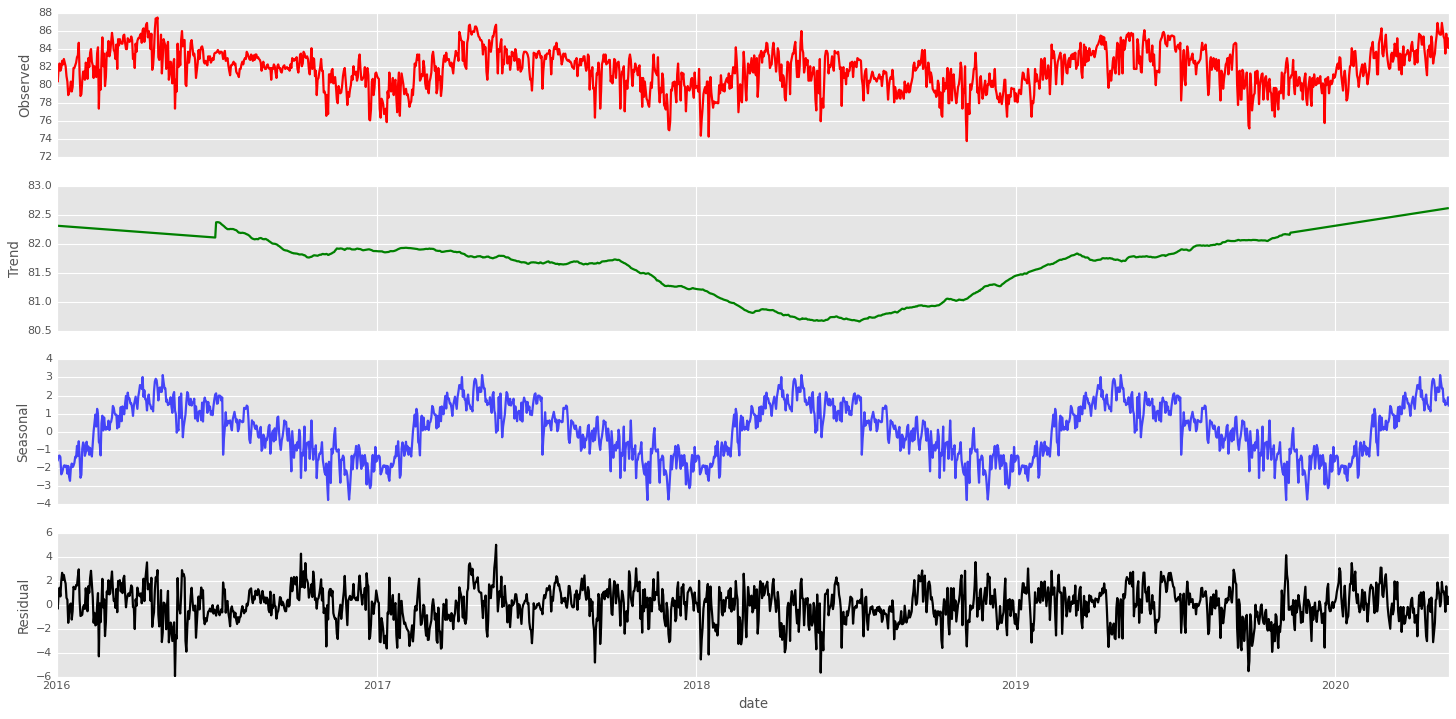

In [41]:
plt.style.use('ggplot')


fig, axes = plt.subplots(4, 1, sharex=True,figsize=(20,10))

result_ts.observed.plot(ax=axes[0], legend=False, color='r',lw=2)
axes[0].set_ylabel('Observed')
result_ts.trend.plot(ax=axes[1], legend=False, color='g',lw=2)
axes[1].set_ylabel('Trend')
result_ts.seasonal.plot(ax=axes[2], legend=False, color = 'blue',lw=2, alpha = 0.7)
axes[2].set_ylabel('Seasonal')
result_ts.resid.plot(ax=axes[3], legend=False, color='k',lw=2)
axes[3].set_ylabel('Residual')
plt.show()

In [42]:
p = d = q = range(0, 2)
#generate patterns from p,q,r
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]


In [43]:
t = process_time()
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                df.AvgTemperature,
                order=param, seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False)
            results = mod.fit()
            print('SARIMA{}*{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

elapsed_time = process_time() - t            
print(elapsed_time)

SARIMA(0, 0, 0)*(0, 0, 0, 12)12 - AIC:18531.386041702623
SARIMA(0, 0, 0)*(0, 0, 1, 12)12 - AIC:16309.939918280812
SARIMA(0, 0, 0)*(0, 1, 0, 12)12 - AIC:6949.998824375231
SARIMA(0, 0, 0)*(0, 1, 1, 12)12 - AIC:6443.981468062659
SARIMA(0, 0, 0)*(1, 0, 0, 12)12 - AIC:6955.429451542568
SARIMA(0, 0, 0)*(1, 0, 1, 12)12 - AIC:6496.135536547775
SARIMA(0, 0, 0)*(1, 1, 0, 12)12 - AIC:6590.704482823819
SARIMA(0, 0, 0)*(1, 1, 1, 12)12 - AIC:6452.826558588837
SARIMA(0, 0, 1)*(0, 0, 0, 12)12 - AIC:16365.489839115657
SARIMA(0, 0, 1)*(0, 0, 1, 12)12 - AIC:14205.979769476537
SARIMA(0, 0, 1)*(0, 1, 0, 12)12 - AIC:6475.081759264413
SARIMA(0, 0, 1)*(0, 1, 1, 12)12 - AIC:5852.664881917144
SARIMA(0, 0, 1)*(1, 0, 0, 12)12 - AIC:6483.965599837158
SARIMA(0, 0, 1)*(1, 0, 1, 12)12 - AIC:6566.3258459557965
SARIMA(0, 0, 1)*(1, 1, 0, 12)12 - AIC:6075.947883043253
SARIMA(0, 0, 1)*(1, 1, 1, 12)12 - AIC:5854.661305221154
SARIMA(0, 1, 0)*(0, 0, 0, 12)12 - AIC:5697.23475788938
SARIMA(0, 1, 0)*(0, 0, 1, 12)12 - AIC:5663.0

In [44]:
model = SARIMAX(df.AvgTemperature,
                order=(1, 1,1), seasonal_order=(0, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

results_SARIMA = model.fit()

In [45]:
pred = results_SARIMA.get_prediction(start=pd.to_datetime('2018-05-01'), 
                              dynamic=False, full_results=True)
pred_ci = pred.conf_int()

In [46]:
results_SARIMA.get_prediction(start=pd.to_datetime('2018-05-01'),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

In [47]:
results_SARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     AvgTemperature   No. Observations:                 1592
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2669.035
Date:                            Fri, 03 Sep 2021   AIC                           5346.071
Time:                                    17:30:16   BIC                           5367.493
Sample:                                01-01-2016   HQIC                          5354.034
                                     - 05-10-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5068      0.026     19.265      0.000       0.455       0.558
ma.L1         -1.0939      0.015    -73.238      0.000      -1.123      -1.065
ma.S.L12      -0.9791      0.009   -107.361      0.000      -0.997      -0.961
sigma2         1.4534      0.058     24.870      0.000       1.339       1.568
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):               317.80
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -0.72
Prob(H) (two-sided):                  0.62   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMA predictions

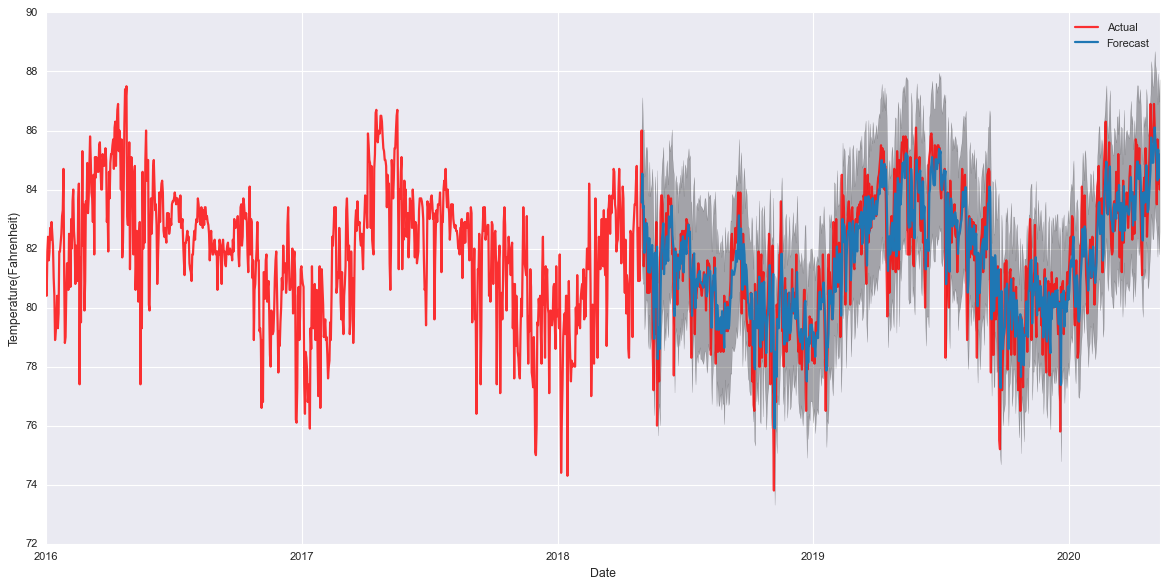

In [48]:
plt.style.use('seaborn')
plt.figure(figsize=(16,8))
ax = df.AvgTemperature['2016':].plot(label='Actual',lw=2, color='red',alpha=0.8)
pred.predicted_mean.plot(ax=ax, label='Forecast',lw=2,color='tab:blue')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.3)
ax.set_xlabel('Date')
ax.set_ylabel('Temperature(Fahrenheit)')
plt.legend()
plt.show()

### RMSE of SARIMA

In [49]:
y_forecasted = pred.predicted_mean
y_truth = df.AvgTemperature['2018-05-01':]

rmse = sqrt(mean_squared_error(y_truth, y_forecasted).mean())
print('RMSE test data {}'.format(round(rmse, 2)))


RMSE test data 1.32


### LSTM

In [50]:
df_lstm = dt_2[["date", "AvgTemperature"]]
print(df_lstm.count())
print(df_lstm.describe())

date              9266
AvgTemperature    9266
dtype: int64
       AvgTemperature
count     9266.000000
mean        74.241420
std         35.401923
min        -99.000000
25%         79.700000
50%         81.500000
75%         82.900000
max         88.300000


In [51]:
df_lstm["AvgTemperature"] = df_lstm["AvgTemperature"].mask(df_lstm["AvgTemperature"] == -99, median)

### Resampling the data

In [52]:
df_lstm.set_index('date', inplace=True)
print(df.head(5))
df_week = df_lstm.resample('MS').mean()
df_week.count()

            AvgTemperature
date                      
2016-01-01            80.8
2016-01-02            80.4
2016-01-03            81.9
2016-01-04            82.4
2016-01-05            81.6


AvgTemperature    305
dtype: int64

In [53]:
train_data = df_week[:len(df_week)-12]
test_data = df_week[len(df_week)-12:]

df_week.count()

AvgTemperature    305
dtype: int64

In [54]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data.iloc[:,:1])

In [55]:
n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

lstm_model2 = Sequential()
lstm_model2.add(LSTM(100,return_sequences=True, activation='relu',input_shape=(n_input, n_features)))
lstm_model2.add(LSTM(50,activation='relu',return_sequences=True))
lstm_model2.add(LSTM(5,activation='relu'))
lstm_model2.add(Dense(1))
lstm_model2.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [56]:
t = process_time()
lstm_model2.fit(generator,epochs=70,verbose=0)
elapsed_time = process_time() - t

In [57]:
print(elapsed_time)

526.984375


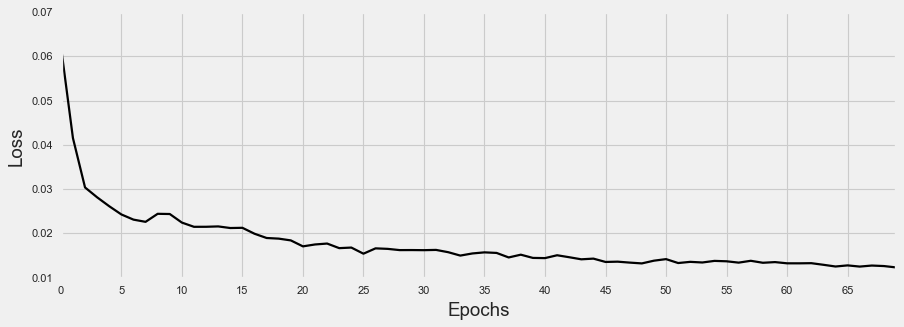

In [58]:
plt.style.use('fivethirtyeight')
losses_lstm2 = lstm_model2.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,70,5))
plt.plot(range(len(losses_lstm2)),losses_lstm2,lw=2,color = 'black')
plt.show()

In [59]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_data)):   
    lstm_pred2 = lstm_model2.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred2) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [60]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

test_data['LSTM_Predictions'] = lstm_predictions

test_data

,AvgTemperature,LSTM_Predictions
date,,
2019-06-01,83.976667,82.451789
2019-07-01,82.851613,81.809053
2019-08-01,82.096774,81.281351
2019-09-01,80.706667,80.872096
2019-10-01,79.516129,79.867872
2019-11-01,80.486667,79.827595
2019-12-01,80.032258,81.110215
2020-01-01,81.480645,81.188180
2020-02-01,83.137931,81.467539


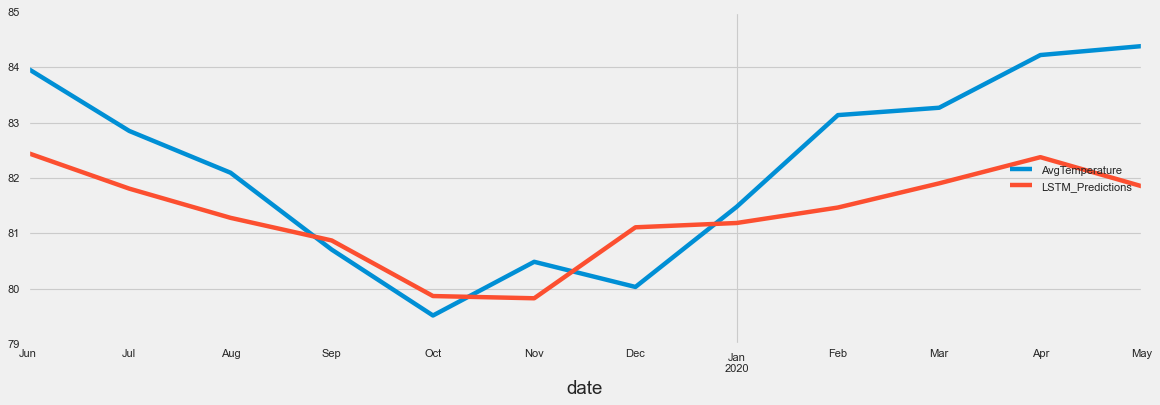

In [61]:
test_data['AvgTemperature'].plot(figsize = (16,5), legend=True)
test_data['LSTM_Predictions'].plot(legend = True);
plt.legend(loc='right')
plt.show()

In [62]:
test_data = pd.DataFrame(test_data)
lstm_rmse_error = sqrt(mean_squared_error(test_data['AvgTemperature'], test_data["LSTM_Predictions"]).mean())

print(f'RMSE Error: {lstm_rmse_error}')

RMSE Error: 1.3033339634939165
